In [8]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe
import pandas as pd

In [20]:
with xr.open_dataset("~/Downloads/InGOS_Radon_fluxmap_v2.0_noah_2006-2012.nc") as f:
    ds_flux_rn = f.load()

In [21]:
# Time is currently in a float with the format YYYYMMDD. Convert to datetime
dates = [str(int(date)) for date in ds_flux_rn.time.values]
ds_flux_rn['time'] = [pd.to_datetime(date) for date in dates]

In [22]:
# Import NAME grid from footprint file
with xr.open_dataset("../data/fp_RGL-90magl_UKV_EUROPE_part.nc") as f:
    ds_fp_rn = f.load()

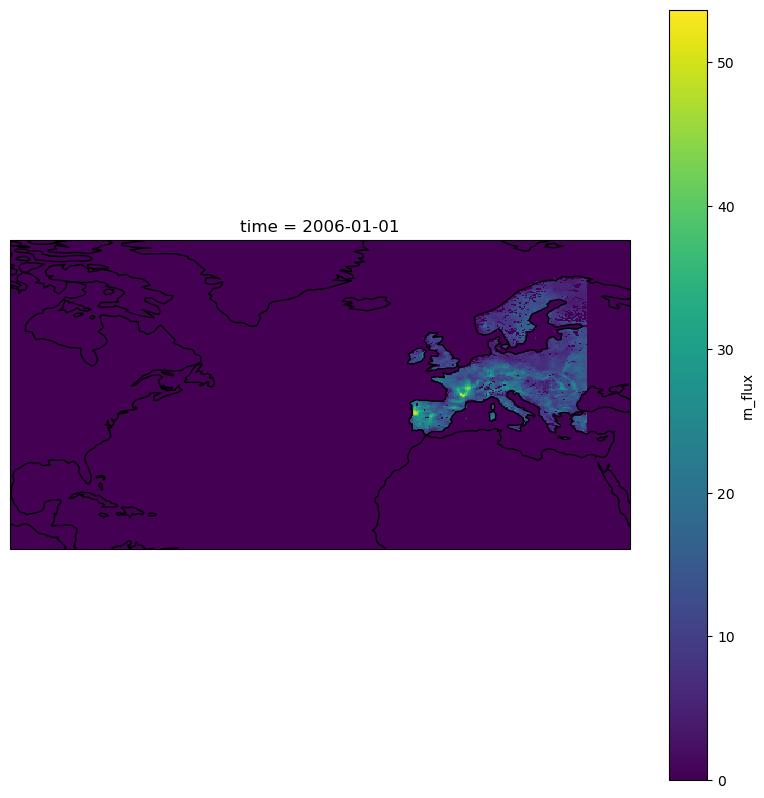

In [24]:
# Use xesmf to regrid the radon flux to the NAME grid
regridder = xe.Regridder(ds_flux_rn, ds_fp_rn, 'bilinear')
ds_flux_rn_regrid = regridder(ds_flux_rn)

# replace Nans with zeros
ds_flux_rn_regrid = ds_flux_rn_regrid.fillna(0)

# Plot the regridded radon flux
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ds_flux_rn_regrid['rn_flux'].sel({"time": "2006-01-01"}).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')
plt.show()


In [16]:
ds_flux_rn_regrid

<xarray.Dataset>
Dimensions:  (time: 84, lat: 293, lon: 391)
Coordinates:
  * time     (time) float64 2.006e+07 2.006e+07 ... 2.012e+07 2.012e+07
  * lon      (lon) float32 -97.9 -97.55 -97.2 -96.84 ... 38.32 38.68 39.03 39.38
  * lat      (lat) float32 10.73 10.96 11.2 11.43 ... 78.36 78.59 78.82 79.06
Data variables:
    rn_flux  (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear